In [1]:
from data import load_data
import sklearn
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
import os 

# Parameters

In [2]:
dataset='GunPoint'

# Load Data

In [3]:
#TODO include OneHot Encoding Options
train_x,test_x, train_y, test_y = load_data.load_basic_dataset(dataset,scaling=None,mode='torch',cwd='/media/jacqueline/Data/UCRArchive_2018/')

In [4]:
print(test_y.shape)

(150,)


In [5]:
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
pickle.dump(enc1,open(f'./ClassificationModels/models/{dataset}/OneHotEncoder.pkl','wb'))

train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))
    

# Model Training

In [6]:
n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)
model = ResNetBaseline(in_channels=1, num_pred_classes=n_pred_classes)
fit(model,train_loader,test_loader)
if dataset in os.listdir('./ClassificationModels/models/'):
    print('Folder exists')
else: 
    os.mkdir(f'./ClassificationModels/models/{dataset}')
torch.save(model.state_dict(), f'./ClassificationModels/models/{dataset}/ResNet')

test_preds, ground_truth = get_all_preds(model, test_loader)
ground_truth=np.argmax(ground_truth,axis=1)

sns.set(rc={'figure.figsize':(5,4)})
heatmap=confusion_matrix(ground_truth, test_preds)
sns.heatmap(heatmap, annot=True)
plt.savefig(f'./ClassificationModels/models/{dataset}/ResNet_confusion_matrix.png')
plt.close()
acc= accuracy_score(ground_truth, test_preds)
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'./ClassificationModels/models/{dataset}/classification_report.csv', index = False)

/home/jacqueline/.local/share/virtualenvs/InterpretabiltyTimeSeries-y2AnfPaS/lib/python3.7/site-packages/torch/autograd/__init__.py:175: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


Epoch: 1, Train loss: 0.801, Val loss: 0.692
Epoch: 2, Train loss: 0.691, Val loss: 0.708
Epoch: 3, Train loss: 0.791, Val loss: 0.695
Epoch: 4, Train loss: 0.72, Val loss: 0.692
Epoch: 5, Train loss: 0.694, Val loss: 0.692
Epoch: 6, Train loss: 0.694, Val loss: 0.693
Epoch: 7, Train loss: 0.698, Val loss: 0.691
Epoch: 8, Train loss: 0.69, Val loss: 0.69
Epoch: 9, Train loss: 0.692, Val loss: 0.688
Epoch: 10, Train loss: 0.674, Val loss: 0.691
Epoch: 11, Train loss: 0.705, Val loss: 0.695
Epoch: 12, Train loss: 0.701, Val loss: 0.688
Epoch: 13, Train loss: 0.696, Val loss: 0.689
Epoch: 14, Train loss: 0.692, Val loss: 0.69
Epoch: 15, Train loss: 0.698, Val loss: 0.69
Epoch: 16, Train loss: 0.689, Val loss: 0.69
Epoch: 17, Train loss: 0.69, Val loss: 0.691
Epoch: 18, Train loss: 0.695, Val loss: 0.684
Epoch: 19, Train loss: 0.684, Val loss: 0.68
Epoch: 20, Train loss: 0.687, Val loss: 0.695
Epoch: 21, Train loss: 0.715, Val loss: 0.696
Epoch: 22, Train loss: 0.699, Val loss: 0.682
Epoch

# Explanation Algo

In [7]:
item=test_x[0].reshape(1,1,-1)
_item=  torch.from_numpy(item).float()
y_target= model(_item).detach().numpy()

In [8]:
from InterpretabilityModels.counterfactual.Wachter_Counterfactual import W_CF

exp_model=W_CF(model, mode='torch')
exp=exp_model.explain(item, np.argmax(y_target,axis=1))

/media/jacqueline/Data/InterpretabiltyTimeSeries/InterpretabilityModels/counterfactual/Wachter_Counterfactual.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  y_target_proba=torch.nn.functional.one_hot(torch.tensor([y_target]),num_classes=f_x_new.shape[1]).float()


# Plot Item 

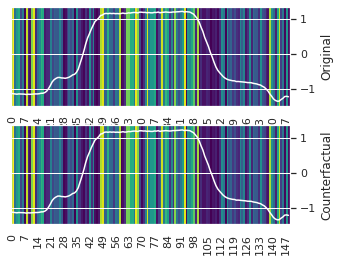

In [9]:
exp_model.plot(item,exp)